# Homogenous 1D Elastic Wave Equation 

In order to explote finite volume solvers we seek to investigate the 1-D elastic wave equation propogating through a homogenous medium. The source free elastic wave equation can be written a coupled sytems of equation 
$$
\begin{gather*}
    \frac{\partial}{\partial t} \sigma - \mu \frac{\partial}{\partial x} v = 0  \\
     \frac{\partial}{\partial t} v - \frac{1}{\rho} \frac{\partial}{\partial x} \sigma = 0 
\end{gather*}
$$
where $\sigma = \sigma_{xy}(x,t)$ is the shear stress component of the stress tensor, $v = v_y(x,t)$ is the transerve velocity, $\rho$ is the density and $\mu$ is the bulk modulus. In matrix vector notation the equation becomes 
$$
\begin{gather*}
    \partial_t \begin{bmatrix} \sigma \\ v \end{bmatrix} + \begin{bmatrix} 0 & -\mu \\ -1/\rho & 0 \end{bmatrix} \partial_x \begin{bmatrix} \sigma \\ v \end{bmatrix} = 0
\end{gather*}
$$
which simplifies to 
$$
    \partial_t Q + A \partial_x Q = 0. 
$$
Our elastic wave eqaution above is analgous to the 1-D advection equation except our equations above are a couple system of equations. In order to make use  of the well documented numerical methods for the 1-D advection equation we must decouple this system. We seek to show that the equation is hyperbolic by demonstarting that $A$ is diagonalizable with real eigenvalues. We are looking for the eigenvalue decomposition of $A$ such that 
$$
\begin{equation*}
    A = X \Lambda X^{-1}\\
\end{equation*}
$$
By subbing in the the eigendecompostion of $A$ into our matrix vector form of our equation and multiplying both sides of the equation by $X^{-1}$ we get 
$$
\begin{equation*}
   X^{-1} \partial_t Q +X^{-1} X \Lambda X^{-1} \partial_x Q = 0. 
\end{equation*}
$$
where the $X^{-1}Q = W$ the solution vector. Simplying the equation 
$$
\begin{equation*}
   \partial_t W + \Lambda \partial_x W = 0. 
\end{equation*}
$$
we now have a decoupled equation which allows us to utilize the numerical methods derived for the advection equation. We find the eigenvalues of $A$ to be 
$$
\begin{align*}
    Ax &= \lambda x \\
    (A-\lambda I )x &= 0 \\
    \det\left|\begin{matrix} -\lambda & -\mu\\ -1/\rho & -\lambda\end{matrix} \right| &= 0\\
    \lambda & = \pm \sqrt{\mu/\rho} = \pm C
\end{align*}
$$
where $C$ is the shear stress velocity. Therefore the eigenvectors of $A$ are 
$$
\begin{align*}
    \begin{bmatrix} C & -\mu \\ -1/\rho & C \end{bmatrix} \begin{bmatrix} x_1 \\ x_2\end{bmatrix} = 0, && x_1 = \begin{bmatrix} \rho c \\ 1 \end{bmatrix}
\end{align*}
$$
and 
$$
\begin{align*}
    \begin{bmatrix} -C & -\mu \\ -1/\rho & -C \end{bmatrix} \begin{bmatrix} x_1 \\ x_2\end{bmatrix} = 0, && x_2 = \begin{bmatrix} -\rho c \\ 1 \end{bmatrix}.
\end{align*}
$$
Which now have our matrix of eigenvectors
$$
\begin{align*}
    X = \begin{bmatrix} pc & -pc \\ 1 & 1\end{bmatrix}
\end{align*}
$$
for which the inverse is 
$$
\begin{align*}
    X^{-1} = \frac{1}{2\rho c} \begin{bmatrix} 1 & pc \\ -1 & pc\end{bmatrix}
\end{align*}
$$
meaning we have a full eigendecompsotion of $A$ such that 
$$
\begin{align*}
    A = \begin{bmatrix} pc & -pc \\ 1 & 1 \end{bmatrix} \begin{bmatrix} -c & 0 \\ 0 & c \end{bmatrix} \frac{1}{2\rho c} \begin{bmatrix} 1 & pc \\ -1 & pc\end{bmatrix}
\end{align*}
$$

## Intializing and inital conditions 

In [1]:
import numpy as np 
from scipy import linalg as LA 
import matplotlib.pyplot as plt 
from matplotlib import animation, rc
rc('animation', html='html5')


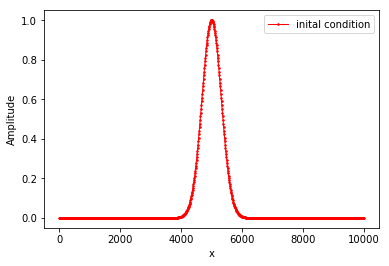

In [17]:
# Material Properties 
# -----------------------------------------------------
C   = 2500              # velcoity (m/s) 
rho = 2500              # density  (kg/m^3) 
Z   = rho*C             # impedance (kg/(s m^2))
mu  = rho*C**2          # bluk modulus 

# Model Domain 
# -----------------------------------------------------
nx  = 1000              # number of grid cells
L   = 10*1000           # domain length (m)
cfl = 0.9               # Counrant Number 
T   = 2                 # length of simulation (s)

# Inital Conditions
# -----------------------------------------------------
bet = 5e-6              # arugments in initial cond.
gam = 2e-5              # arugments in initial cond.
x0  = 5000              # postion of the initial conidition 

# Initalizing spatial domain 
x, dx = np.linspace(0,L,nx,retstep=True)

# Calculate time step based on CFL criterion 
dt  = cfl*dx/C
nt  = int(np.floor(T/dt))

# Initalize solution matrix
Q   = np.zeros((2,nx,nt))
#Q_n = np.zeros((2,nx,nt))

# Inital condition
# -----------------------------------------------------
Q[0,:,0]  = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))

# Plot inital condition
# -----------------------------------------------------
plt.plot(x,  Q[0,:,0],'r-o', lw=1, markersize=1.5,  label="inital condition")
plt.ylabel('Amplitude')
plt.xlabel('x')
plt.legend()
#plt.savefig('./test.eps')

In [8]:
Q.shape

(2, 1000, 555)

## Local Python Solutions 

We now decompose the solution into left and right propogating vectors as
$$
\begin{align}
\Lambda^+ = \begin{bmatrix} -c & 0 \\ 0 & 0 \end{bmatrix}, && \Lambda^- = \begin{bmatrix} 0 & 0 \\ 0 & c \end{bmatrix}, && A^{\pm} = X \Lambda^{\pm} X^{-1}
\end{align}
$$

In [3]:
X    = np.array([[Z,-Z],[1,1]])             # Eigenvector Matrix
Xinv = 1/(2*Z) * np.array([[1,Z],[-1,Z]])   # Inverse of eigenvector Matrix
LamP = np.array([[ 0,0],[0,C]])             # Positive Lambda
LamM = np.array([[-C,0],[0,0]])             # Negative Lambda
AP   = X @ LamP @ Xinv                      # Postive decomposed A
AM   = X @ LamM @ Xinv                      # Negative decomposed A
A    = np.array([[0, -mu],[-1/rho,0]])      # Coefficent matrix A

In [14]:
for n in range(nt):
    for j in range(1,nx-1):  
        dQl = Q[:,j] - Q[:,j-1]
        dQr = Q[:,j+1] - Q[:,j]
        Q_n[:,j] = Q[:,j] - (dt/dx) * (AP.dot(dQl) + AM.dot(dQr)) 
    Q_n[:,0] = Q_n[:,1]
    Q_n[:,-1] = Q_n[:,-2]

    Q, Q_n   = Q_n.copy(), Q.copy()

In [26]:
# 3-D Array
# -----------------------------------------------------
for n in range(nt-1):
    for j in range(1,nx-1):  
        dQl = Q[:,j,n] - Q[:,j-1,n]
        dQr = Q[:,j+1,n] - Q[:,j,n]
        Q[:,j,n+1] = Q[:,j,n] - (dt/dx) * (AP.dot(dQl) + AM.dot(dQr)) 
    Q[:,0,n+1]  = Q[:,1,n+1]
    Q[:,-1,n+1] = Q[:,-2,n+1]

In [44]:
fig, ax = plt.subplots(1,1)
line, = ax.plot([], [], lw=2) 
ax.set_xlim((0, L))
ax.set_ylim((-0.1, 1.1))

def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line,

def animate(i):  
    global x,Q
    line.set_data(x, Q[0,:,i])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=range(0,nt), interval=10, blit=True)
plt.close()

In [45]:
anim